## Finding Correlated stocks in Indian Banking Sector

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


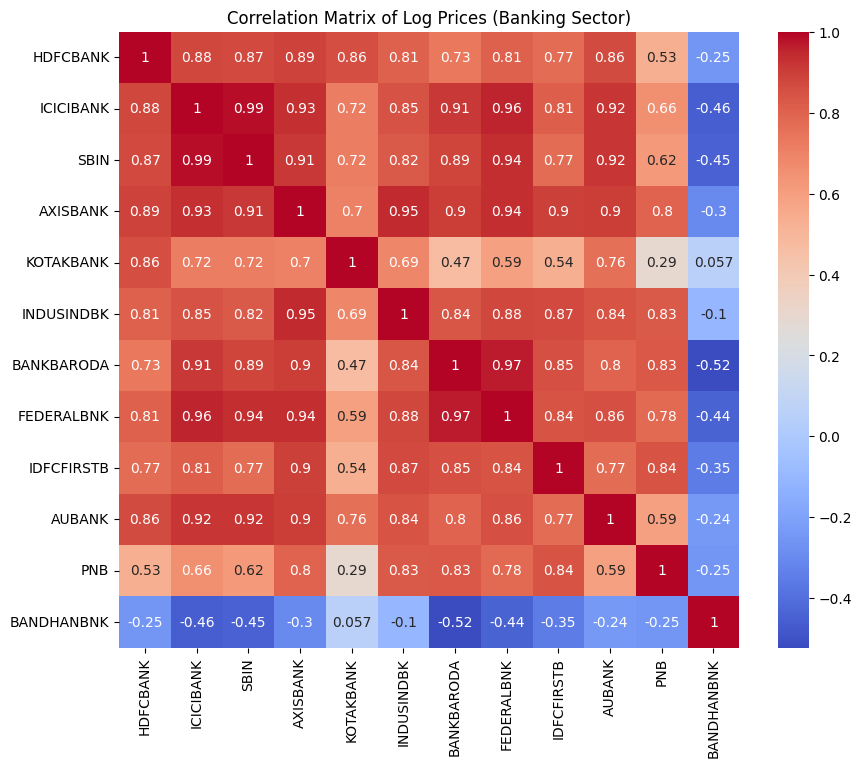

Top correlated stock pairs in banking sector:
ICICIBANK   SBIN          0.986770
BANKBARODA  FEDERALBNK    0.966895
ICICIBANK   FEDERALBNK    0.956530
AXISBANK    INDUSINDBK    0.945732
            FEDERALBNK    0.940331
dtype: float64


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Define the ticker symbols (Yahoo Finance format)
tickers = {
    'HDFCBANK': 'HDFCBANK.NS',
    'ICICIBANK': 'ICICIBANK.NS',
    'SBIN': 'SBIN.NS',
    'AXISBANK': 'AXISBANK.NS',
    'KOTAKBANK': 'KOTAKBANK.NS',
    'INDUSINDBK': 'INDUSINDBK.NS',
    'BANKBARODA': 'BANKBARODA.NS',
    'FEDERALBNK': 'FEDERALBNK.NS',
    'IDFCFIRSTB': 'IDFCFIRSTB.NS',
    'AUBANK': 'AUBANK.NS',
    'PNB': 'PNB.NS',
    'BANDHANBNK': 'BANDHANBNK.NS'
}
data = pd.DataFrame()

for i in tickers.values():
    data_test = yf.download(i, start="2020-01-01", end="2024-01-01")['Close']
    data[i] = data_test

data.columns = tickers.keys()  # Rename columns back to stock names

# Step 4: Compute the correlation matrix
corr_matrix = data.corr()

# Step 5: Display heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Log Prices (Banking Sector)")
plt.show()

# Step 6: Extract top N correlated pairs (excluding self-correlation)
def get_top_correlated_pairs(corr_matrix, top_n=5):
    pairs = (
        corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        .stack()
        .sort_values(ascending=False)
    )
    return pairs.head(top_n)

top_pairs = get_top_correlated_pairs(corr_matrix, top_n=5)
print("Top correlated stock pairs in banking sector:")
print(top_pairs)


## Verifying Correlation

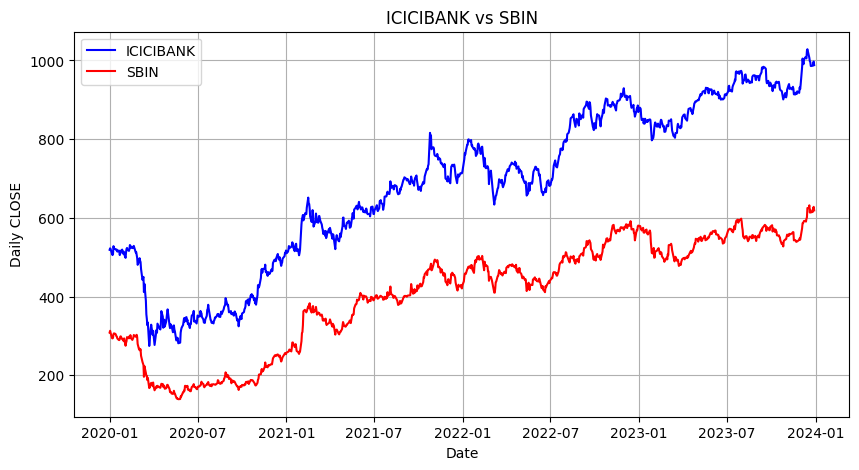

In [2]:
plt.figure(figsize=(10, 5))
plt.plot(data['ICICIBANK'], label='ICICIBANK', color='blue')
plt.plot(data['SBIN'], label='SBIN', color='red')
plt.title('ICICIBANK vs SBIN')
plt.xlabel('Date')  
plt.ylabel('Daily CLOSE') 
plt.legend()
plt.grid(True)
plt.show()


Pearson Correlation Coefficient: 0.6955
P-value: 4.0235e-144


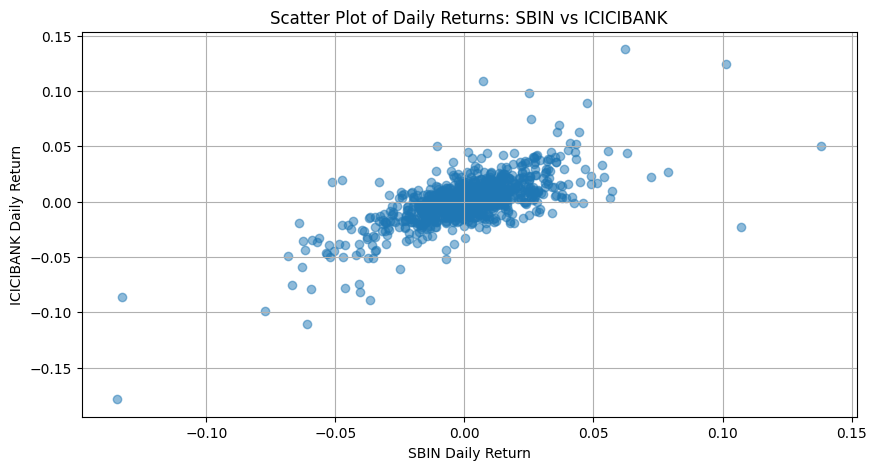

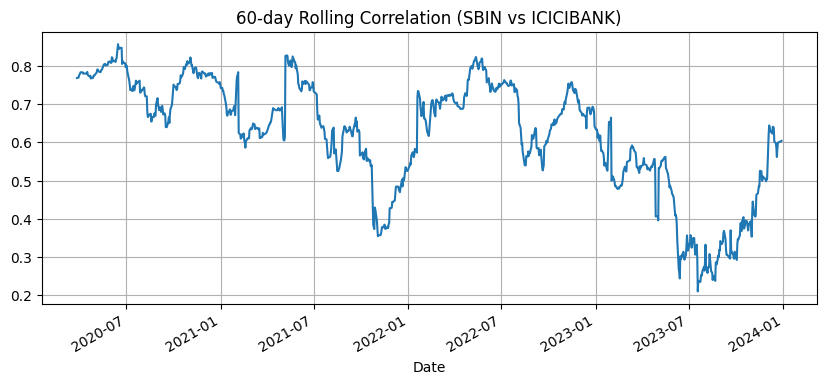

In [3]:
from scipy.stats import pearsonr

LIST = ['ICICIBANK', 'SBIN']
returns = data[LIST].pct_change().dropna()

data

# Step 3: Compute Pearson correlation
corr_value, p_value = pearsonr(returns['SBIN'], returns['ICICIBANK'])

print(f"Pearson Correlation Coefficient: {corr_value:.4f}")
print(f"P-value: {p_value:.4e}")

# Step 4: Plot returns
plt.figure(figsize=(10, 5))
plt.scatter(returns['SBIN'], returns['ICICIBANK'], alpha=0.5)
plt.title('Scatter Plot of Daily Returns: SBIN vs ICICIBANK')
plt.xlabel('SBIN Daily Return')
plt.ylabel('ICICIBANK Daily Return')
plt.grid(True)
plt.show()

# Step 5: Rolling correlation (Optional)
rolling_corr = returns['SBIN'].rolling(window=60).corr(returns['ICICIBANK'])
rolling_corr.plot(figsize=(10, 4), title='60-day Rolling Correlation (SBIN vs ICICIBANK)')
plt.grid(True)
plt.show()

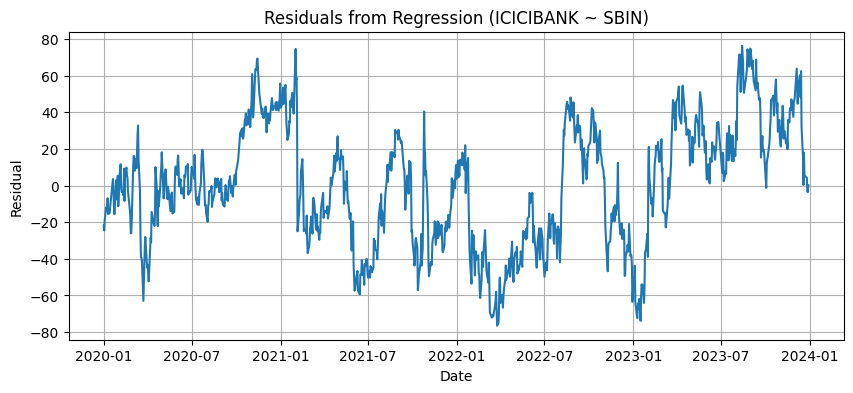

ADF Statistic: -3.6335046733060796
p-value: 0.00515186646552164
Critical Value 1%: -3.437013049776705
Critical Value 5%: -2.864481711583566
Critical Value 10%: -2.5683363157264196


In [4]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

X = sm.add_constant(data['SBIN'])  # Add intercept
y = data['ICICIBANK']  # Dependent variable
model = sm.OLS(y, X).fit()
residuals = model.resid

# Step 3: Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Residuals from Regression (ICICIBANK ~ SBIN)")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.grid(True)
plt.show()

# Step 4: ADF test on residuals (Engle-Granger step 2)
adf_result = adfuller(residuals)

# Step 5: Print ADF test results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value {key}: {value}")



## Visualizing Our Strategy entry and exit

In [5]:
# ICICIBANK = y
# SBIN = X
# when residual is strong positive it indicated that either x will go up and y will go down 
# when residual is negative that indicates that x will go down and y will go up

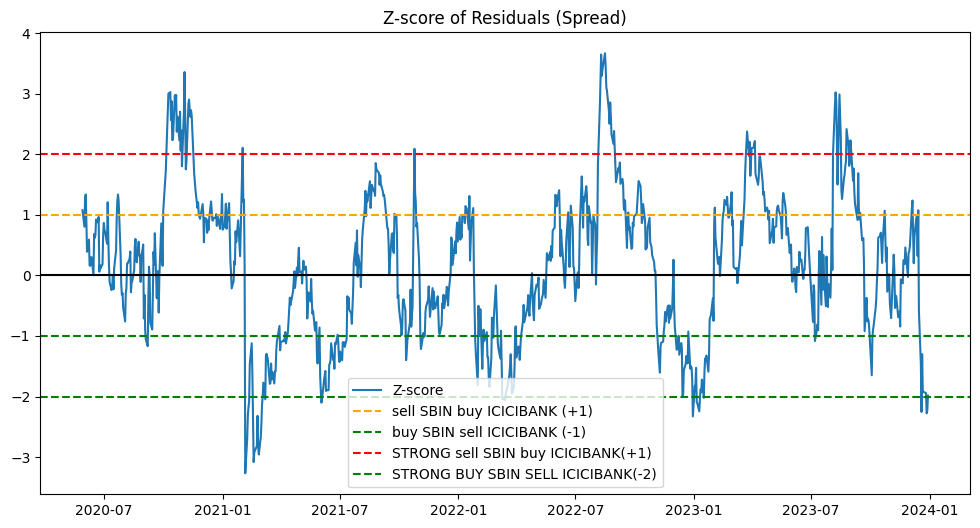

In [6]:
lookback = 100  # You can tune this window
mean = residuals.rolling(window=lookback).mean()
std = residuals.rolling(window=lookback).std()

# Step 2: Compute z-score
z_score = (residuals - mean) / std

# Step 3: Plot z-score
plt.figure(figsize=(12, 6))
plt.plot(z_score, label='Z-score')
plt.axhline(1.0, color='orange', linestyle='--', label='sell SBIN buy ICICIBANK (+1)')
plt.axhline(-1.0, color='green', linestyle='--', label='buy SBIN sell ICICIBANK (-1)')
plt.axhline(2.0, color='red', linestyle='--', label='STRONG sell SBIN buy ICICIBANK(+1)')
plt.axhline(-2.0, color='green', linestyle='--', label='STRONG BUY SBIN SELL ICICIBANK(-2)')
plt.axhline(0.0, color='black', linestyle='-')
plt.legend()
plt.title('Z-score of Residuals (Spread)')
plt.show()

## executing strategy in backtrader

#### the model params

In [7]:
beta = model.params['SBIN']
intercept = model.params['const']

print(f"OLS Model: y = {intercept:.4f} + {beta:.4f} * x")

OLS Model: y = 96.0772 + 1.4407 * x


#### preparing the data

In [8]:
import backtrader as bt
data0 = yf.download('SBIN.NS', start="2020-01-01", end="2024-01-01")
data1 = yf.download('ICICIBANK.NS', start="2020-01-01", end="2024-01-01")
data0.columns = ['close' , "high" , "low", "open", "volume"]
data1.columns = ['close' , "high" , "low", "open", "volume"]
sbin = bt.feeds.PandasData(dataname=data0, datetime= None, close = 0 , high= 1, low= 2, open= 3, volume= 4 , openinterest= -1)
icici = bt.feeds.PandasData(dataname=data1, datetime= None, close = 0 , high= 1, low= 2, open= 3, volume= 4 , openinterest= -1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
cerebro = bt.Cerebro()
cerebro.adddata(sbin)
cerebro.adddata(icici)
cerebro.broker.setcash(100000)

#### preparing the strategy

In [10]:

class PairsTradingStrategy(bt.Strategy):
    params = dict(window=100, entry_z=1, exit_z=0.3)

    def __init__(self):
        self.residuals = []
        self.order = None
        self.agressive = False

    def next(self):
        if len(self) <= self.p.window:
            residual = self.datas[1].close[0] - (intercept + beta * self.datas[0].close[0])
            # print(f"{self.datas[0].datetime.date(0)} residual is  {residual}")
            self.residuals.append(residual)
            return
        

        residual = self.datas[1].close[0] - (intercept + beta * self.datas[0].close[0])
        self.residuals.append(residual)
        window_resid = self.residuals[-self.p.window:]
        mean = np.mean(window_resid)
        std = np.std(window_resid)
        z_score = (residual - mean) / std
        #print(f"{self.datas[0].datetime.date(0)}: Z-score = {z_score:.2f}")
        pos_x = self.getposition(self.datas[0])
        pos_y = self.getposition(self.datas[1])
        print(f"{self.datas[0].datetime.date(0)}: Position X: {pos_x.size}, Position Y: {pos_y.size}")
        #print(f"{self.datas[0].datetime.date(0)}: . account balance is {cerebro.broker.getvalue()}")

        if pos_x.size == 0 and pos_y.size == 0:
            if z_score > self.p.entry_z:
                # Short y, Long x (simplified with market orders)
                #print(f"{self.datas[0].datetime.date(0)}: SHORT Y, LONG X (Z={z_score:.2f})")
                size = int((cerebro.broker.getvalue()/6) / self.datas[0].close[0])  # one-tenth of the account value
                self.order = self.sell(data=self.datas[1], size=15000)
                self.order = self.buy(data=self.datas[0], size=15000)

            elif z_score < -self.p.entry_z:
                # Long y, Short x (simplified with market orders)
                #print(f"{self.datas[0].datetime.date(0)}: LONG Y, SHORT X (Z={z_score:.2f})")
                size = int((cerebro.broker.getvalue()/6) / self.datas[0].close[0])  # one-tenth of the account value
                self.order = self.buy(data=self.datas[1], size=15000)
                self.order = self.sell(data=self.datas[0], size=15000)
        else:

            # More aggressive position if z-score exceeds 2
            if z_score > 2.0:
                if self.agressive:
                    #print(f"{self.datas[0].datetime.date(0)}: Already in aggressive mode, skipping (Z={z_score:.2f})")
                    return
                self.agressive = True
                #print(f"{self.datas[0].datetime.date(0)}: ADDING TO SHORT Y, LONG X (Z={z_score:.2f})")
                size = int((cerebro.broker.getvalue()/3) / self.datas[0].close[0])  # one-tenth of the account value
                self.order = self.buy(data=self.datas[1], size=25000)
                self.order = self.sell(data=self.datas[0], size=25000)

            elif z_score < -2.0:
                if self.agressive:
                    #print(f"{self.datas[0].datetime.date(0)}: Already in aggressive mode, skipping (Z={z_score:.2f})")
                    return
                self.agressive = True
                #print(f"{self.datas[0].datetime.date(0)}: ADDING TO LONG Y, SHORT X (Z={z_score:.2f})")
                size = int((cerebro.broker.getvalue()/3) / self.datas[0].close[0])  # one-tenth of the account value
                self.order = self.buy(data=self.datas[1], size=25000)
                self.order = self.sell(data=self.datas[0], size=25000)

            elif abs(z_score) < self.p.exit_z:
                print(f"{self.datas[0].datetime.date(0)}: EXITING POSITION (Z={z_score:.2f})")
                self.close(data=self.datas[0])
                self.close(data=self.datas[1])
                self.agressive = False
                self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            action = "BUY" if order.isbuy() else "SELL"
            print(f"{self.datas[0].datetime.date(0)}: {action} EXECUTED at {order.executed.price:.2f}")
            self.order = None  # Reset order after execution

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print(f"{self.datas[0].datetime.date(0)}: Order Canceled/Margin/Rejected")
            self.order = None

    
        
    


In [11]:
class PortfolioValueTracker(bt.Analyzer):
    def __init__(self):
        self.portfolio_values = []

    def next(self):
        date = self.strategy.datas[0].datetime.date(0)
        value = self.strategy.broker.getvalue()
        self.portfolio_values.append((date, value))

    def get_analysis(self):
        return self.portfolio_values


In [12]:
cerebro.addstrategy(PairsTradingStrategy)
cerebro.broker.setcash(10000000)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', timeframe=bt.TimeFrame.Days, riskfreerate=0.01)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addanalyzer(PortfolioValueTracker, _name='portfolio_tracker')

results = cerebro.run()
strat = results[0]


2020-06-01: Position X: 0, Position Y: 0
2020-06-02: Position X: 0, Position Y: 0
2020-06-03: SELL EXECUTED at 345.97
2020-06-03: BUY EXECUTED at 159.17
2020-06-03: Position X: 15000, Position Y: -15000
2020-06-04: Position X: 15000, Position Y: -15000
2020-06-05: Position X: 15000, Position Y: -15000
2020-06-08: Position X: 15000, Position Y: -15000
2020-06-09: Position X: 15000, Position Y: -15000
2020-06-09: EXITING POSITION (Z=0.16)
2020-06-10: SELL EXECUTED at 170.29
2020-06-10: BUY EXECUTED at 336.93
2020-06-10: Position X: 0, Position Y: 0
2020-06-11: Position X: 0, Position Y: 0
2020-06-12: Position X: 0, Position Y: 0
2020-06-15: Position X: 0, Position Y: 0
2020-06-16: Position X: 0, Position Y: 0
2020-06-17: Position X: 0, Position Y: 0
2020-06-18: Position X: 0, Position Y: 0
2020-06-19: Position X: 0, Position Y: 0
2020-06-22: Position X: 0, Position Y: 0
2020-06-23: Position X: 0, Position Y: 0
2020-06-24: Position X: 0, Position Y: 0
2020-06-25: Position X: 0, Position Y

In [13]:
print("\nPerformance Metrics:")
print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")
print(f"Sharpe Ratio: {strat.analyzers.sharpe.get_analysis().get('sharperatio', 'NA')}")
print(f"Max Drawdown: {strat.analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")

# Trade Stats
trades = strat.analyzers.trades.get_analysis()
total_trades = trades.total.closed if 'closed' in trades.total else 0
won = trades.won.total if 'won' in trades else 0
lost = trades.lost.total if 'lost' in trades else 0

print(f"Total Trades: {total_trades}")
print(f"Wins: {won} | Losses: {lost}")
if total_trades > 0:
    print(f"Win Rate: {100 * won / total_trades:.2f}%")



Performance Metrics:
Final Portfolio Value: 20122341.60
Sharpe Ratio: 0.09519099773216844
Max Drawdown: 10.84%
Total Trades: 70
Wins: 44 | Losses: 26
Win Rate: 62.86%


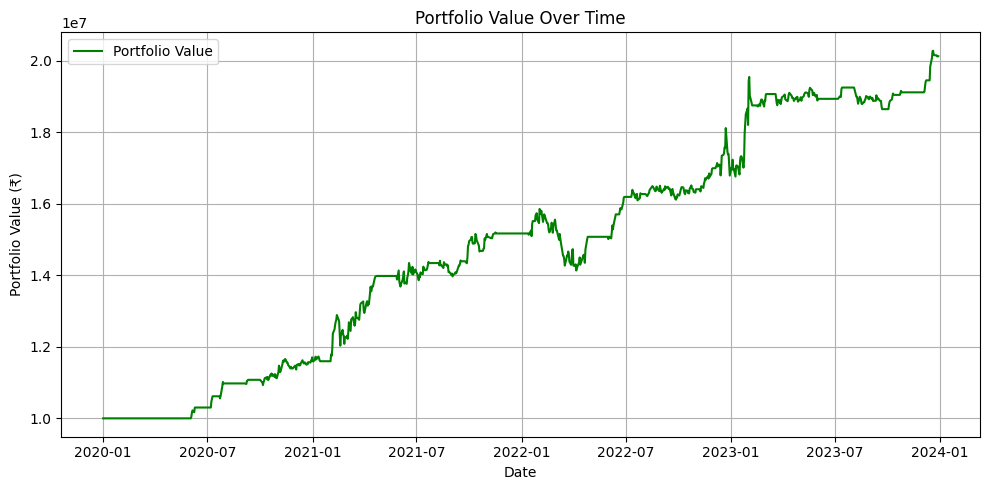

In [15]:
# Split date and value
portfolio_data = strat.analyzers.portfolio_tracker.get_analysis()
dates, values = zip(*portfolio_data)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(dates, values, label='Portfolio Value', color='green')
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (₹)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()